In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import json
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import collections
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.model_selection import GridSearchCV
import datetime, time
import pytz
import statsmodels.api as stats_api
import pickle as pickle_
import csv

/Users/satya/Anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Popularity Prediction

#### Initialize variables

In [2]:
hashtags = ['#gopatriots','#nfl','#sb49','#gohawks','#patriots','#superbowl'] #using only one tag
#hashtags = ['#sb49','#gohawks','#patriots','#superbowl'] #using only one tag
df_map = {} # to store dfs for each file

#### Reading files into dataframes and storing

In [3]:
import os
df_columns = ['timestamp','tweet_id','author_id','followers','retweets','title','location']
bypass = False
for hashtag in hashtags:
    df = pd.DataFrame(columns=df_columns)
    lno = 0
    print("Processing ",hashtag)
    with open("tweet_data/tweets_"+hashtag+".txt", "r") as file_obj:
        if(not os.path.isfile('temp/'+hashtag+'.csv') or bypass):
            writer=csv.writer(open('temp/'+hashtag+'.csv','w'))
            writer.writerow(df_columns)
            line = file_obj.readline()
            while(line):
                if(lno%20000 == 0):
                    print(lno)
                j = json.loads(line)
                lno+=1
                timestamp =j['citation_date']
                followers =j['author']['followers']
                retweets = j['metrics']['citations']['total']
                author_id = j['author']['url']
                tweet_id = j['tweet']['id']
                title = j['title']
                location=j['tweet']['user']['location']
                writer.writerow([timestamp,tweet_id,author_id,followers,retweets,title,location])
                line = file_obj.readline()
        else:
            print("File Exists!")
            #writer.close()

Processing  #gopatriots
File Exists!
Processing  #nfl
File Exists!
Processing  #sb49
File Exists!
Processing  #gohawks
File Exists!
Processing  #patriots
File Exists!
Processing  #superbowl
File Exists!


In [4]:
df_map = {}

In [5]:
for hashtag in hashtags:
    print('loaded dataframe',hashtag)
    df_map[hashtag] = pd.read_csv('temp/'+hashtag+'.csv')


loaded dataframe #gopatriots
loaded dataframe #nfl
loaded dataframe #sb49
loaded dataframe #gohawks
loaded dataframe #patriots
loaded dataframe #superbowl


## 1.1 Statistics

In [6]:
tweets_hrly = {}
retweets_avg = {}
followers_hrly = {}
tweets_cnt = {}
retweets_cnt = {}
followers_cnt = {}

for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag]
    sec = df['timestamp'].max() - df['timestamp'].min()   
    tweets_cnt[hashtag] = df['tweet_id'].count()
    retweets_cnt[hashtag] = df['retweets'].sum()
    followers_cnt[hashtag] = df['followers'].sum()
    tweets_hrly[hashtag] = (tweets_cnt[hashtag]*3600)/sec
    retweets_avg[hashtag] = (retweets_cnt[hashtag])/tweets_cnt[hashtag]
    followers_hrly[hashtag] = (followers_cnt[hashtag])/tweets_cnt[hashtag]    


#gopatriots
#nfl
#sb49
#gohawks
#patriots
#superbowl


In [7]:
print('Tweets Count : ',tweets_cnt)
print('Tweets Avg. hourly',tweets_hrly)
print('Retweets Count : ',retweets_cnt)
print('Retweets Avg. hourly',retweets_avg)

print('Followers Count : ',followers_cnt)
print('Followers Avg. hourly',followers_cnt)

Tweets Count :  {'#gopatriots': 26232, '#nfl': 259024, '#sb49': 826951, '#gohawks': 188136, '#patriots': 489713, '#superbowl': 1348761}
Tweets Avg. hourly {'#gopatriots': 45.694510573562027, '#nfl': 441.3234311373958, '#sb49': 1419.8879074871904, '#gohawks': 325.3715913043311, '#patriots': 834.55550916418849, '#superbowl': 2309.9309809384081}
Retweets Count :  {'#gopatriots': 36727, '#nfl': 398517, '#sb49': 2076597, '#gohawks': 379022, '#patriots': 873068, '#superbowl': 3221210}
Retweets Avg. hourly {'#gopatriots': 1.4000838670326319, '#nfl': 1.5385331089011056, '#sb49': 2.5111487863247035, '#gohawks': 2.014617085512608, '#patriots': 1.7828156491659402, '#superbowl': 2.3882733857221554}
Followers Count :  {'#gopatriots': 36774523.0, '#nfl': 1205304020.0, '#sb49': 8490567936.0, '#gohawks': 414638907.0, '#patriots': 1620939662.0, '#superbowl': 11948576274.0}
Followers Avg. hourly {'#gopatriots': 36774523.0, '#nfl': 1205304020.0, '#sb49': 8490567936.0, '#gohawks': 414638907.0, '#patriots'

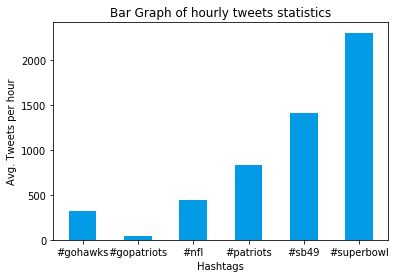

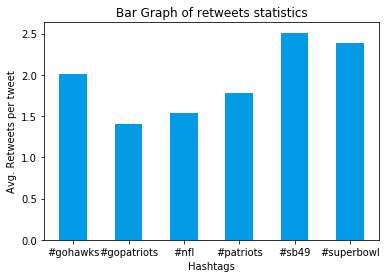

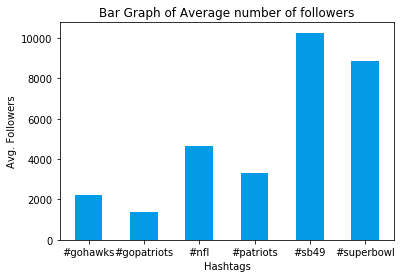

In [8]:
plt.bar(tweets_hrly.keys(),tweets_hrly.values(), width=0.5, color='#039BE5')
plt.title('Bar Graph of hourly tweets statistics')
plt.xlabel('Hashtags')
plt.ylabel('Avg. Tweets per hour')
plt.show()
plt.bar(retweets_avg.keys(),retweets_avg.values(), width=0.5, color='#039BE5')
plt.title('Bar Graph of retweets statistics')
plt.xlabel('Hashtags')
plt.ylabel('Avg. Retweets per tweet')
plt.show()
plt.bar(followers_hrly.keys(),followers_hrly.values(), width=0.5, color='#039BE5')
plt.title('Bar Graph of Average number of followers')
plt.xlabel('Hashtags')
plt.ylabel('Avg. Followers')
plt.show()

#### Returns the hour number from timestamp

In [9]:
pst_tz = pytz.timezone('US/Mountain')
def getHourofDay(timestamp):
    #print(timestamp)
    return datetime.datetime.fromtimestamp(timestamp, pst_tz).hour

    
def getHour(timestamp):
    return datetime.datetime.fromtimestamp(int(timestamp/3600)*3600, pst_tz)

#superbowl
                  timestamp  tweet_id
0 2015-01-14 01:00:00-07:00         8
585


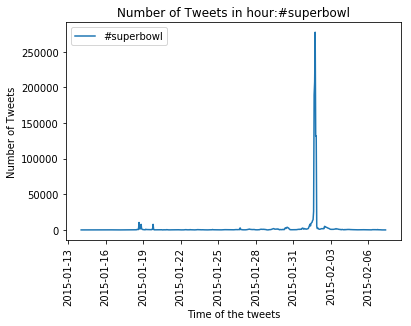

#nfl
                  timestamp  tweet_id
0 2015-01-14 01:00:00-07:00        59
583


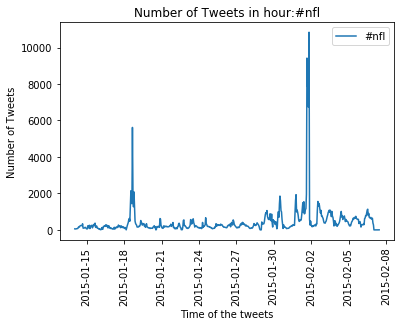

In [10]:
for hashtag in ['#superbowl','#nfl']:
    print(hashtag)
    df = df_map[hashtag].copy()
    df['timestamp'] = df['timestamp'].apply(lambda x:getHour(x) )
    grouped = df.groupby('timestamp').agg({'tweet_id':'count'})
    #grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    #grouped.columns=grouped.columns.droplevel()
    
    grouped.reset_index(inplace=True)
    print(grouped.head(1))
    grouped = grouped.sort_values(by=['timestamp'])
    plt.plot(list(grouped['timestamp']),list(grouped['tweet_id']),label=hashtag)
    plt.title('Number of Tweets in hour:'+hashtag)
    print(len(list(grouped['tweet_id'])))
    plt.xticks(rotation=90)
    plt.ylabel('Number of Tweets')
    plt.xlabel('Time of the tweets')
    plt.legend()
    plt.show()


## 1.2 Linear Regression

In [11]:
X_map = {}
Y_map = {}
for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag].copy()
    df['timestamp'] = df['timestamp'].apply(lambda x:getHour(x) )
    grouped = df.groupby('timestamp').agg({'followers': ['sum', 'max'],'tweet_id':'count', 'retweets':'sum'})
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    grouped.reset_index(inplace=True)
    grouped = grouped.sort_values(by=['timestamp'])
    grouped['hour_of_day'] = grouped.apply(lambda x: x['timestamp'].hour, axis=1)
    X_map[hashtag] = grouped.drop(['timestamp'],axis=1)
    print(grouped.head(1))
    Y_map[hashtag] = grouped['tweet_id_count']
    

#gopatriots
                  timestamp  followers_sum  followers_max  tweet_id_count  \
0 2015-01-14 02:00:00-07:00        10955.0        10955.0               1   

   retweets_sum  hour_of_day  
0             4            2  
#nfl
                  timestamp  followers_sum  followers_max  tweet_id_count  \
0 2015-01-14 01:00:00-07:00       104976.0        10658.0              59   

   retweets_sum  hour_of_day  
0            67            1  
#sb49
                  timestamp  followers_sum  followers_max  tweet_id_count  \
0 2015-01-14 05:00:00-07:00           59.0           59.0               1   

   retweets_sum  hour_of_day  
0             2            5  
#gohawks
                  timestamp  followers_sum  followers_max  tweet_id_count  \
0 2015-01-14 01:00:00-07:00        24989.0        12922.0              30   

   retweets_sum  hour_of_day  
0           460            1  
#patriots
                  timestamp  followers_sum  followers_max  tweet_id_count  \
0 2015-01-14 

#### Method to merge n prev hours

In [12]:
#n : number of hours you want to merge
#f : features in each row
#x : X_map value
#y : Y_map value
def getprev_n_merged(n,f,X,y):
    #print(X.head(1))
    col = []
    for i in range(n):
        col = col + [c+'_prev_'+str(n-i)+'_hrs' for c in X.columns ]
    
    X = X.as_matrix()
    X_new = []
    rnew = []
    for row in X[:n]:
        rnew = rnew + list(row)
    
    X_new.append(rnew)
    for row in X[n:]:
        rnew = rnew[f:]+list(row)
        X_new.append(rnew)
    #print(len(X_new[:-1]),len(list(y[n:])))
    return pd.DataFrame(X_new[:-1],columns=col),list(y)[n:]

In [13]:
f= open("test_sum/test.csv","w+")
from collections import defaultdict
rmses = defaultdict(list)
for n in range(1,6):
    f.write('\n\n*********'+str(n)+'******\n')
    for hashtag in hashtags:
        f.write('\n\n'+hashtag+'\n')
        #print(hashtag)
        X,y= getprev_n_merged(n,5,X_map[hashtag],Y_map[hashtag])
        model = stats_api.OLS(y,X).fit()
        preds = model.predict(X)
        rmses[hashtag].append(np.sqrt(mean_squared_error(y,preds)))
        print(hashtag,np.sqrt(mean_squared_error(y,preds)))
        #print(model.summary())
        f.write(model.summary().as_csv())
f.close()


#gopatriots 209.888800715
#nfl 586.056935306
#sb49 4642.69132899
#gohawks 978.608408106
#patriots 2527.65168294
#superbowl 8020.16334802
#gopatriots 190.669406015
#nfl 545.787689007
#sb49 4265.81125111
#gohawks 958.153132789
#patriots 2485.96207943
#superbowl 7005.76312275
#gopatriots 122.041076818
#nfl 499.60670342
#sb49 4071.54276557
#gohawks 917.100472165
#patriots 2309.34655206
#superbowl 6455.11124441
#gopatriots 113.888490966
#nfl 494.872379343
#sb49 3933.52844922
#gohawks 890.651100265
#patriots 2229.54912418
#superbowl 6279.49835538
#gopatriots 106.750187275
#nfl 482.322180081
#sb49 3867.69750889
#gohawks 886.560523311
#patriots 2173.34602842
#superbowl 6191.51030615


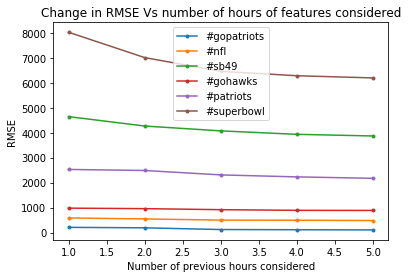

In [14]:
for hashtag in hashtags:
    plt.plot(range(1,6),rmses[hashtag], label=hashtag, marker='.')
#plt.yscale('exponential')
plt.xlabel('Number of previous hours considered')
plt.ylabel('RMSE')
plt.title('Change in RMSE Vs number of hours of features considered')
plt.legend()
plt.show()

# PART 3

In [15]:
def plot_sentiment(hashtags,sentiment_map,hrs,units=' hours'):
    for hashtag in hashtags:
        plt.title("Total Sentiment : subjectivity*polarity for window of "+str(hrs)+units)
        #z = np.polyfit(range(len(sentiment_map[hashtag]['timestamp'])),sentiment_map[hashtag]['sentiment'], 6)
        plt.plot(sentiment_map[hashtag]['timestamp'],list(sentiment_map[hashtag]['sentiment']),label=hashtag)
        #plt.plot(range(len(z)),z,color ='red')
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()
    for hashtag in hashtags:
        plt.title("Average Total Sentiment : subjectivity*polarity for window of "+str(hrs)+units)
        plt.plot(sentiment_map[hashtag]['timestamp'],[(a/b) for a,b in zip(list(sentiment_map[hashtag]['sentiment']),list(sentiment_map[hashtag]['tweet_id'] ))],label=hashtag)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

In [25]:
from textblob import TextBlob as tb
import re
#i=0
def clean_tweet(t):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", t).split())
def get_sentiment(t):
 #   global i
  #  i+=1
   # if(i%100000 == 0):
    #    print(i)
    analysis = tb(clean_tweet(t))
    return analysis.sentiment.polarity*analysis.sentiment.subjectivity
def get_time_bin(t,h):
    return datetime.datetime.fromtimestamp(int(t/(3600*h))*3600*h, pst_tz)    

In [17]:
slist = {}

In [18]:
def perform_sentiment_analysis(hashtags,df_map,hrs):
    sentiment_map={}
    for hashtag in hashtags:
        i = 0
        print(hashtag)
        df = df_map[hashtag].copy()
        df['sentiment'] = df['title'].apply(lambda x:get_sentiment(x))
        df['timestamp'] = df['timestamp'].apply(lambda x:get_time_bin(x,hrs) )
        grouped = df.groupby('timestamp').agg({'sentiment':'sum','tweet_id':'count'})
        grouped.reset_index(inplace=True)
        grouped = grouped.sort_values(by=['timestamp'])
        sentiment_map[hashtag]=grouped
    #plot_sentiment(hashtags,sentiment_map,hrs)
    return sentiment_map    

In [19]:
for hrs in range(12,13):
    i=0
    slist[hrs]= perform_sentiment_analysis(hashtags,df_map,hrs)

#gopatriots
#nfl
100000
200000
#sb49
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
#gohawks
1200000
1300000
#patriots
1400000
1500000
1600000
1700000
#superbowl
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000


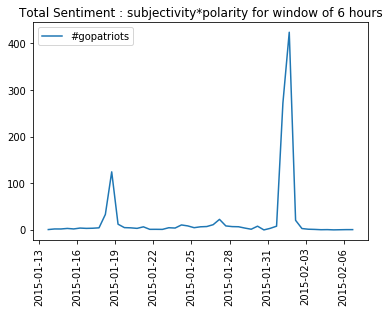

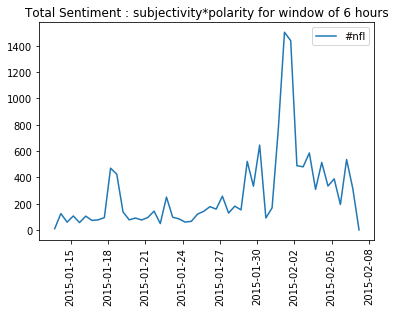

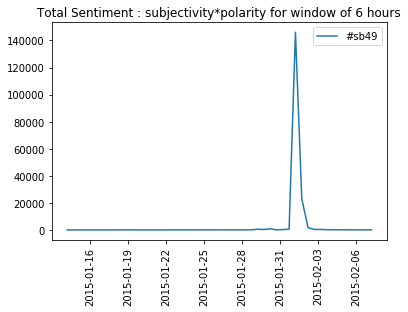

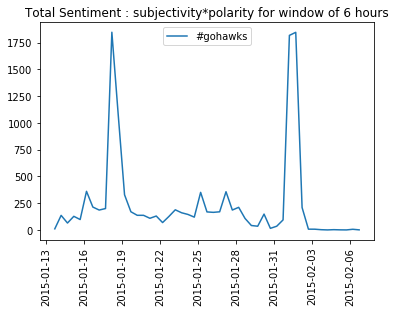

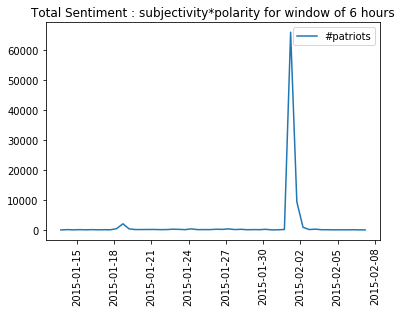

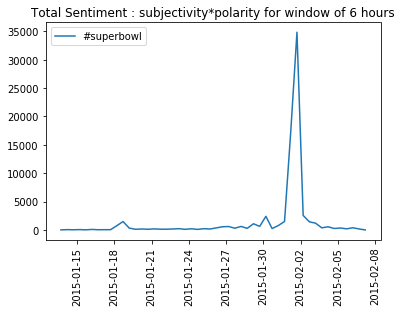

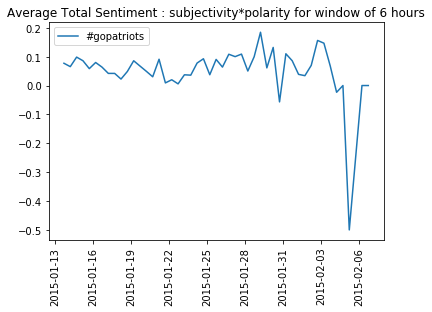

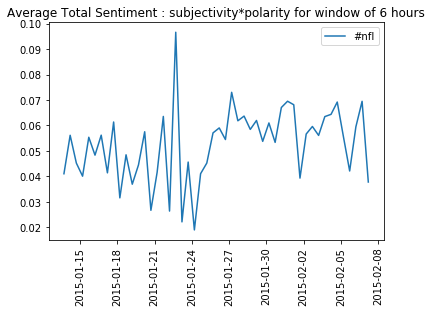

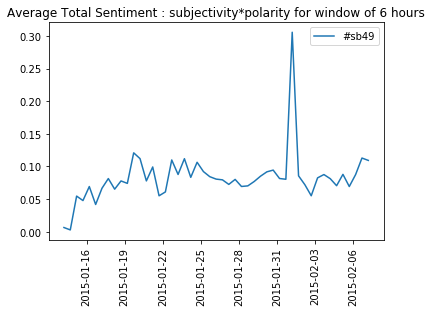

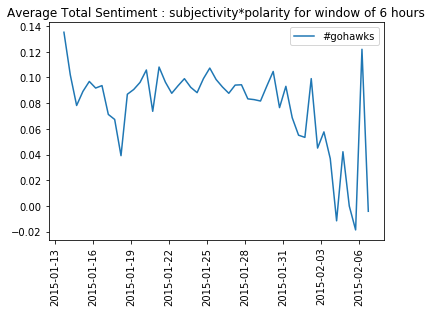

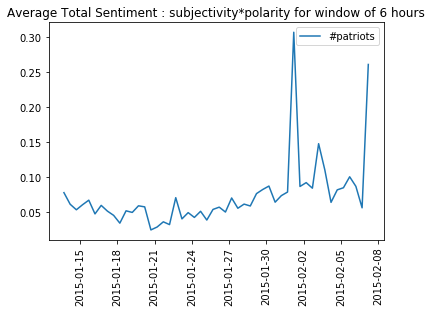

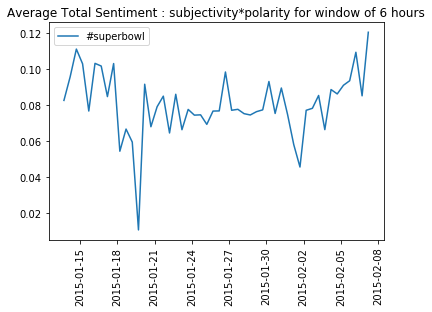

In [20]:
plot_sentiment(hashtags,slist[12],6)

In [21]:
print(slist.keys())

dict_keys([12])


In [22]:
for h in hashtags:
    f = open('total_'+h+'.txt', 'w')
    #print(game_tweet[h]['sentiment'])
    zl = zip(list(slist[12][h]['timestamp']),list(slist[12][h]['sentiment']))
    #l = [str(a)+'\t'+b for a,b in zl]
    for i,j in zl:
        f.write(str(i))
        f.write('\t'+str(j)+'\n')
    f.close()

In [23]:
for h in hashtags:
    f = open('avg_'+h+'.txt', 'w')
    #print(game_tweet[h]['sentiment'])
    avg_sm = [(a/b) for a,b in zip(list(slist[12][h]['sentiment']),list(slist[12][h]['tweet_id'] ))]
    zl = zip(list(slist[12][h]['timestamp']),avg_sm)
    #l = [str(a)+'\t'+b for a,b in zl]
    for i,j in zl:
        f.write(str(i))
        f.write('\t'+str(j)+'\n')
    f.close()

# Part 3 - 2

In [26]:
pst_tz = pytz.timezone('US/Mountain')
start_time = datetime.datetime.fromtimestamp(1422833400, pst_tz)
end_time = datetime.datetime.fromtimestamp(1422847800, pst_tz)
# before = datetime.datetime(2015,2,1,8,0,0)
# after = datetime.datetime(2015,2,1,20,0,0)
def timefromstamp(t):
    return datetime.datetime.fromtimestamp(t, pst_tz)
start_ = 1422833400
end_ = 1422847800
game_tweets = {}
for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag]
    df_game = df[(df['timestamp'] > start_) & (df['timestamp'] < end_)].copy()
    df_game['timestamp'] = df_game['timestamp'].apply(lambda x : int(x/120)*120)
    df_game['sentiment'] = df_game['title'].apply(lambda x:get_sentiment(x))
    #print(df_game['timestamp'].head)
    print(len(df_game['timestamp']))
    grouped = df_game.groupby('timestamp').agg({'sentiment':'sum','tweet_id':'count'})
    
    grouped.reset_index(inplace=True)
    print(len(grouped['timestamp']))
    print(len(np.unique(grouped['timestamp'])))    
    grouped['timestamp'] = grouped['timestamp'].apply(lambda x : timefromstamp(x) )
    print(len(np.unique(grouped['timestamp'])))
    
    grouped = grouped.sort_values(by=['timestamp'])
    game_tweets[hashtag]=grouped
    print(grouped.head(3))
    

#gopatriots
13058
120
120
120
                  timestamp  sentiment  tweet_id
0 2015-02-01 16:30:00-07:00   2.046289       233
1 2015-02-01 16:32:00-07:00   3.965479       191
2 2015-02-01 16:34:00-07:00   4.732711       145
#nfl
36072
120
120
120
                  timestamp   sentiment  tweet_id
0 2015-02-01 16:30:00-07:00  140.789045       552
1 2015-02-01 16:32:00-07:00   13.762989       364
2 2015-02-01 16:34:00-07:00   11.631565       263
#sb49
291418
120
120
120
                  timestamp   sentiment  tweet_id
0 2015-02-01 16:30:00-07:00  640.014943      4689
1 2015-02-01 16:32:00-07:00  566.481828      3266
2 2015-02-01 16:34:00-07:00  525.074188      2676
#gohawks
35886
120
120
120
                  timestamp  sentiment  tweet_id
0 2015-02-01 16:30:00-07:00  18.920728       811
1 2015-02-01 16:32:00-07:00  12.031410       485
2 2015-02-01 16:34:00-07:00  16.141636       346
#patriots
107803
120
120
120
                  timestamp   sentiment  tweet_id
0 2015-02-01 16:30:00-07

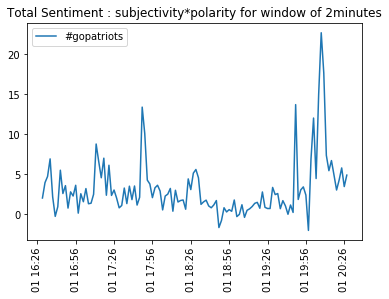

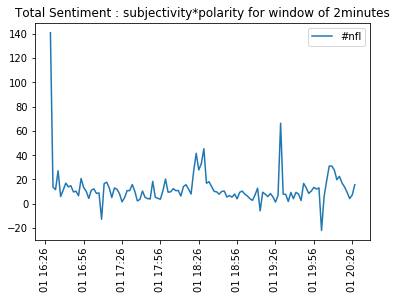

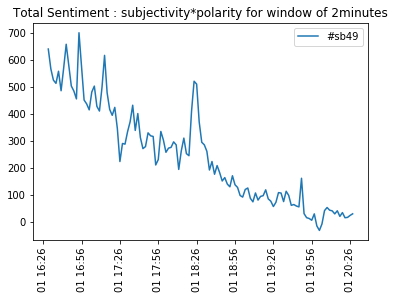

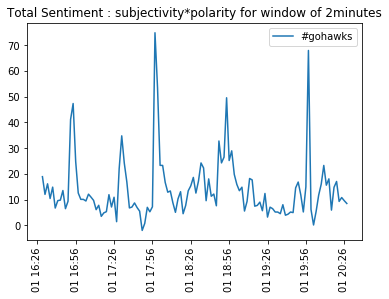

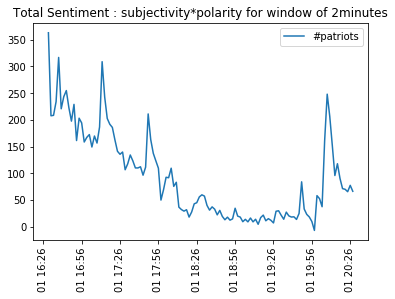

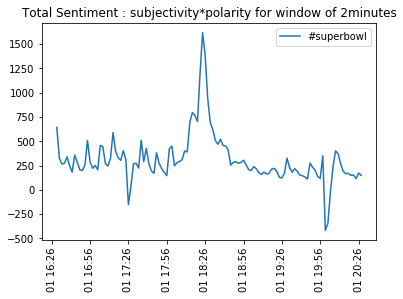

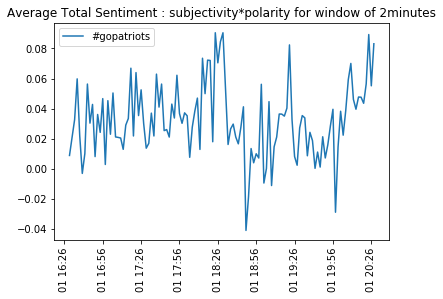

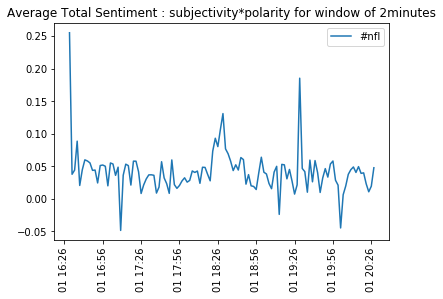

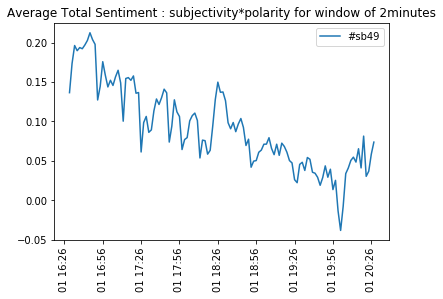

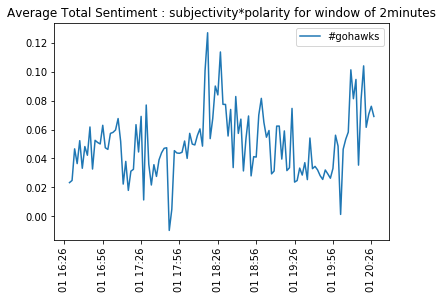

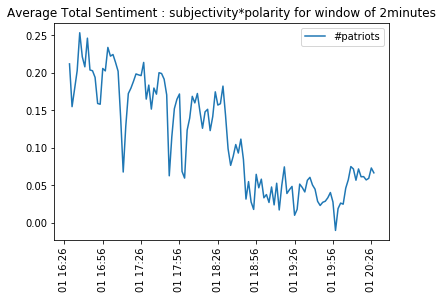

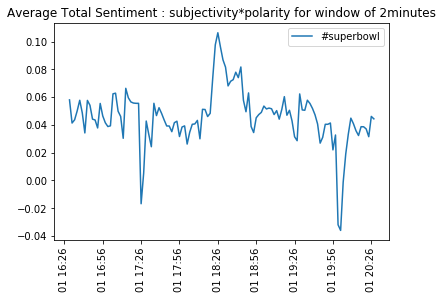

In [27]:
plot_sentiment(hashtags, game_tweets,2,'minutes')

In [28]:
for hashtag in hashtags:
    print(len(np.unique(game_tweets[hashtag]['timestamp'])))

120
120
120
120
120
120


In [29]:
for h in hashtags:
    f = open('avg_gametime'+h+'.txt', 'w')
    #print(game_tweet[h]['sentiment'])
    avg_sm = [(a/b) for a,b in zip(list(game_tweets[h]['sentiment']),list(game_tweets[h]['tweet_id'] ))]
    zl = zip(list(game_tweets[h]['timestamp']),avg_sm)
    #l = [str(a)+'\t'+b for a,b in zl]
    for i,j in zl:
        f.write(str(i))
        f.write('\t'+str(j)+'\n')
    f.close()

In [30]:
pickle_.dump(game_tweets,open('pickle/game_tweets.p','wb'))

In [31]:
pickle_.dump(slist,open('pickle/slist.p','wb'))